In [9]:
import pandas as pd
import numpy as np
import sklearn
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


In [10]:
selected_df = pd.read_csv('./dataset/ifood_selected_columns.csv')
print(selected_df.head())

   Kidhome  Teenhome  Recency  NumDealsPurchases  NumWebPurchases  \
0        0         0       58                  3                8   
1        1         1       38                  2                1   
2        0         0       26                  1                8   
3        1         0       26                  2                2   
4        1         0       94                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  ...  Income_z  NumTotalPurchases  MeanAmtPerPurchase_log  \
0             0  ...  0.314651         

In [23]:
#selected_df.dtypes
nan_check = selected_df.isnull().sum()
nan_cols = nan_check[nan_check > 0]

print("--- 偵測到的 NaN (缺失值) 數量 ---")
if not nan_cols.empty:
    print(nan_cols)
else:
    print("x_train 中沒有 NaN 缺失值。")

--- 偵測到的 NaN (缺失值) 數量 ---
x_train 中沒有 NaN 缺失值。


In [24]:
# 2. 檢查 Inf/-Inf (無窮大)
# np.isinf() 檢查 Inf 或 -Inf
inf_check = selected_df.apply(lambda x: np.isinf(x).sum())
inf_cols = inf_check[inf_check > 0]

print("\n--- 偵測到的 Inf/-Inf (無窮大) 數量 ---")
if not inf_cols.empty:
    print(inf_cols)
else:
    print("x_train 中沒有 Inf/-Inf 無窮大數值。")


--- 偵測到的 Inf/-Inf (無窮大) 數量 ---
MeanAmtPerPurchase_log    2
dtype: int64


In [25]:
# 範例修復 Inf/-Inf 的程式碼：
# 1. 將所有的 Inf 替換為 NaN
selected_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. 用該欄位的平均數或中位數填補 NaN
for col in selected_df.columns:
    if selected_df[col].isnull().any():
        selected_df[col].fillna(selected_df[col].median(), inplace=True)

In [26]:
columns = selected_df.columns.to_list()
print(columns)
y_columns =  ['Response']
x_columns = columns.copy()
x_columns.remove('Response')
print(y_columns)
print(x_columns)

['Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married', 'marital_Single', 'marital_Together', 'marital_Widow', 'education_2n Cycle', 'education_Basic', 'education_Graduation', 'education_Master', 'education_PhD', 'AcceptedCmpOverall', 'Income_z', 'NumTotalPurchases', 'MeanAmtPerPurchase_log', 'MntMeatProducts_ratio', 'MntFishProducts_ratio', 'MntSweetProducts_ratio', 'MntFruits_ratio', 'MntGoldProds_ratio', 'MntWines_ratio', 'MntRegularProds_ratio']
['Response']
['Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Age', 'Customer_Days', 'marital_Divorced', 'marit

In [27]:
y_df = selected_df[y_columns]
x_df = selected_df[x_columns]

In [28]:
#split the dataset into training and testing sets by stratified sampling
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2,stratify=y_df, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1764, 37) (441, 37) (1764, 1) (441, 1)


In [29]:
#initialize the XGBoost classifier 
xgb = XGBClassifier(
    objective = 'binary:logistic',
    use_label_encoder = False,
    eval_metric = 'logloss',
    random_state = 42,
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 5
)

xgb.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [08:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [33]:
# A. 預測機率 (Probability) - 核心輸出
# 用於評估 AUC-ROC，也是行銷活動中排序客戶優先級的基礎
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve


Y_proba = xgb.predict_proba(x_test)[:, 1]

# B. 預測類別 (Prediction) - 基於預設閾值 (0.5)
Y_pred = xgb.predict(x_test)

# 評估指標計算
auc_roc = roc_auc_score(y_test, Y_proba)
accuracy = accuracy_score(y_test, Y_pred)
precision = precision_score(y_test, Y_pred)
recall = recall_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred)

print(f"AUC-ROC Score: {auc_roc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision (精確度): {precision:.4f}")
print(f"Recall (召回率): {recall:.4f}")

AUC-ROC Score: 0.8957
F1 Score: 0.5421
Precision (精確度): 0.7250
Recall (召回率): 0.4328


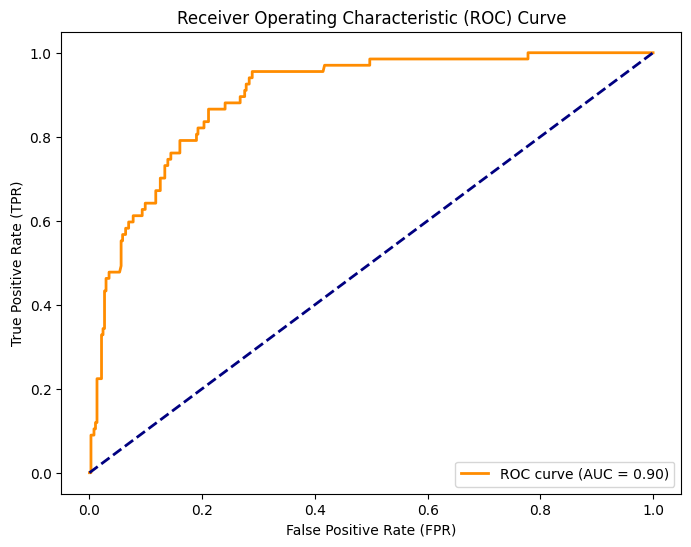

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, Y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.show()

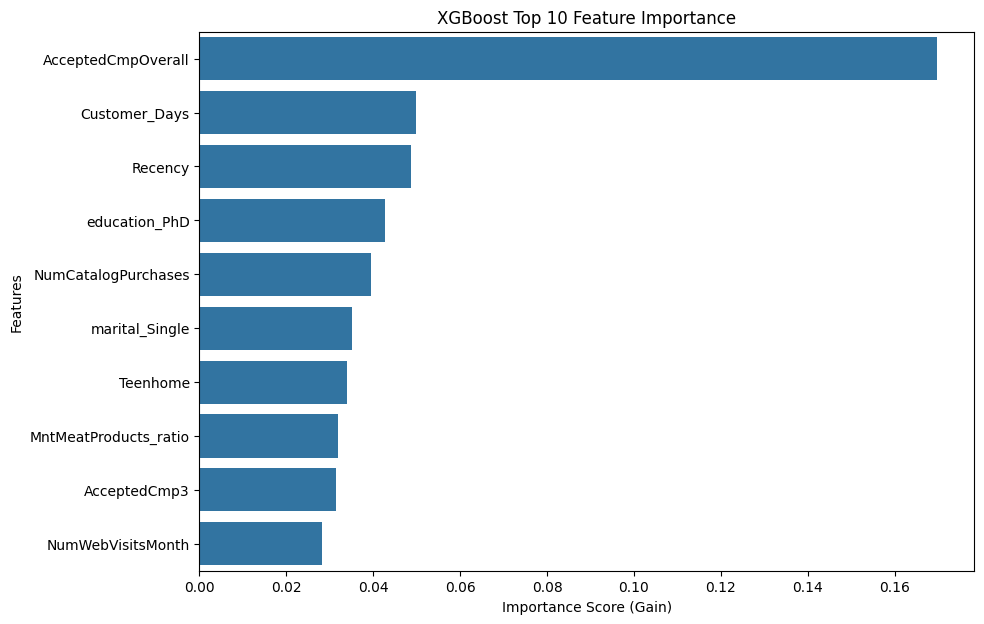

In [35]:
# 繪製特徵重要性圖
feature_importances = pd.Series(xgb.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 7))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('XGBoost Top 10 Feature Importance')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Features')
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, Y_pred)

print("\n--- 混淆矩陣 (Confusion Matrix) ---")
print(f"TN (正確預測未回應): {cm[0, 0]}")
print(f"FP (錯誤預測為回應): {cm[0, 1]}")
print(f"FN (錯失回應客戶): {cm[1, 0]}")
print(f"TP (成功預測回應): {cm[1, 1]}")


--- 混淆矩陣 (Confusion Matrix) ---
TN (正確預測未回應): 363
FP (錯誤預測為回應): 11
FN (錯失回應客戶): 38
TP (成功預測回應): 29
